In [159]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch

class PairwiseImageRetrievalDataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=None):
        """
        Args:
            root_dir (str): Path to the root directory of the dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
            augmentation (callable, optional): Optional augmentation to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.aug = augmentation
        
        # Step 1: Load all images and assign class labels
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Go through each class folder
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    if img_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                        self.image_paths.append(img_path)
                        self.labels.append(idx)
        
        # Create a dictionary of image paths categorized by class
        self.class_images = {}
        for img_path, label in zip(self.image_paths, self.labels):
            if label not in self.class_images:
                self.class_images[label] = []
            self.class_images[label].append(img_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Returns:
            A pair of images, one positive and one negative.
            - image1: A sample image
            - image2: A positive or negative pair
            - label: 1 if positive pair, 0 if negative pair
        """
        # Randomly select the first image (image1)
        img_path1 = self.image_paths[idx]
        label1 = self.labels[idx]
        
        # Load the first image
        image1 = Image.open(img_path1).convert('RGB')
        image1 = np.asarray(image1)
        
        # Apply the augmentations and transformations for image1
        if self.aug:
            image1 = self.aug(image=image1)['image']  # Albumentations requires dict output
        if self.transform:
            image1 = self.transform(image1)
        
        # Randomly select a pair: Positive or Negative
        # Positive pair: same class
        # Negative pair: different class
        is_positive_pair = random.choice([True, False])
        
        if is_positive_pair:
            # Select a positive pair: image from the same class
            positive_img_path = random.choice(self.class_images[label1])
            while positive_img_path == img_path1:  # Ensure it's not the same image
                positive_img_path = random.choice(self.class_images[label1])
            
            image2 = Image.open(positive_img_path).convert('RGB')
            label = 1  # Positive pair
        else:
            # Select a negative pair: image from a different class
            negative_label = random.choice([label for label in self.class_images if label != label1])
            negative_img_path = random.choice(self.class_images[negative_label])
            
            image2 = Image.open(negative_img_path).convert('RGB')
            label = 0  # Negative pair
        image2 = np.asarray(image2)

        # Apply the augmentations and transformations for image2
        if self.aug:
            image2 = self.aug(image=image2)['image']
        if self.transform:
            image2 = self.transform(image2)

        return image1, image2, label

In [92]:
a_transform = A.Compose([
    A.Resize(224, 224),  # Resize images to 224x224
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with a probability of 0.5
    A.Rotate(limit=(-45, 45), p=0.5),  # Randomly rotate within -45 to 45 degrees
])

transform = transforms.Compose([
    transforms.ToTensor(),
])


In [154]:
dataset = PairwiseImageRetrievalDataset(root_dir="/disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop_classes",transform=transform,augmentation=a_transform)

In [155]:
dataset.class_to_idx

{'class_0': 0, 'class_1': 1, 'class_2': 2}

In [156]:
dataset.image_paths

['/disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop_classes/class_0/cropped_box_1.png',
 '/disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop_classes/class_0/cropped_box_0.png',
 '/disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop_classes/class_1/cropped_box_3.png',
 '/disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop_classes/class_1/cropped_box_2.png',
 '/disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop_classes/class_2/cropped_box_7.png',
 '/disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop_classes/class_2/cropped_box_9.png']

In [217]:
img1, img2, label = dataset.__getitem__(5)

filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop_classes/class_2/cropped_box_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_4/trex_result_crop_classes/class_1/cropped_box_3.png


In [180]:
img1.shape

torch.Size([3, 224, 224])

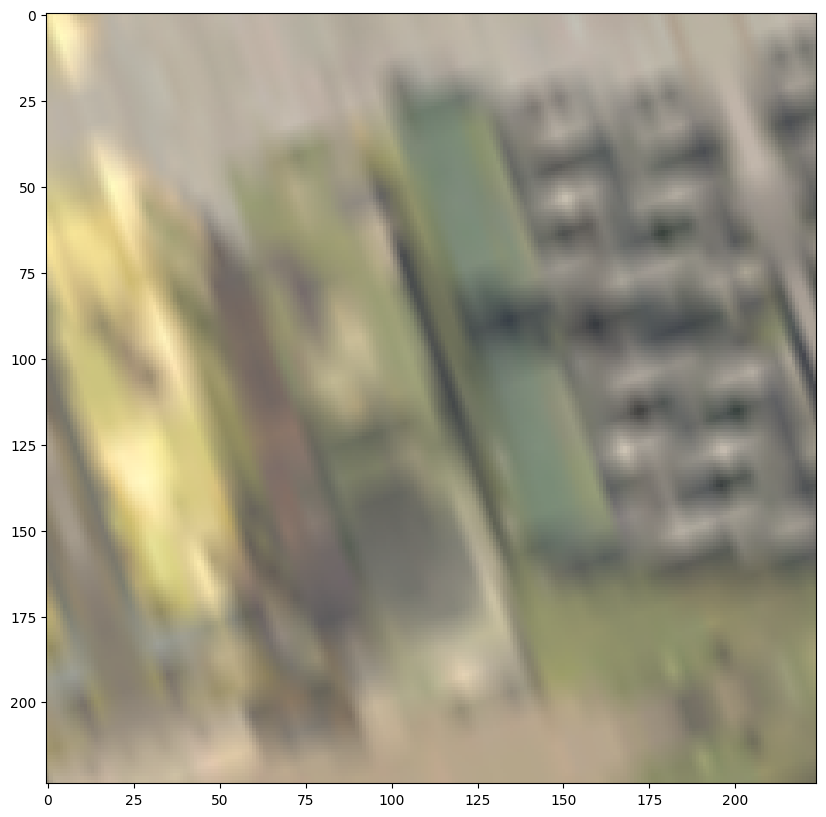

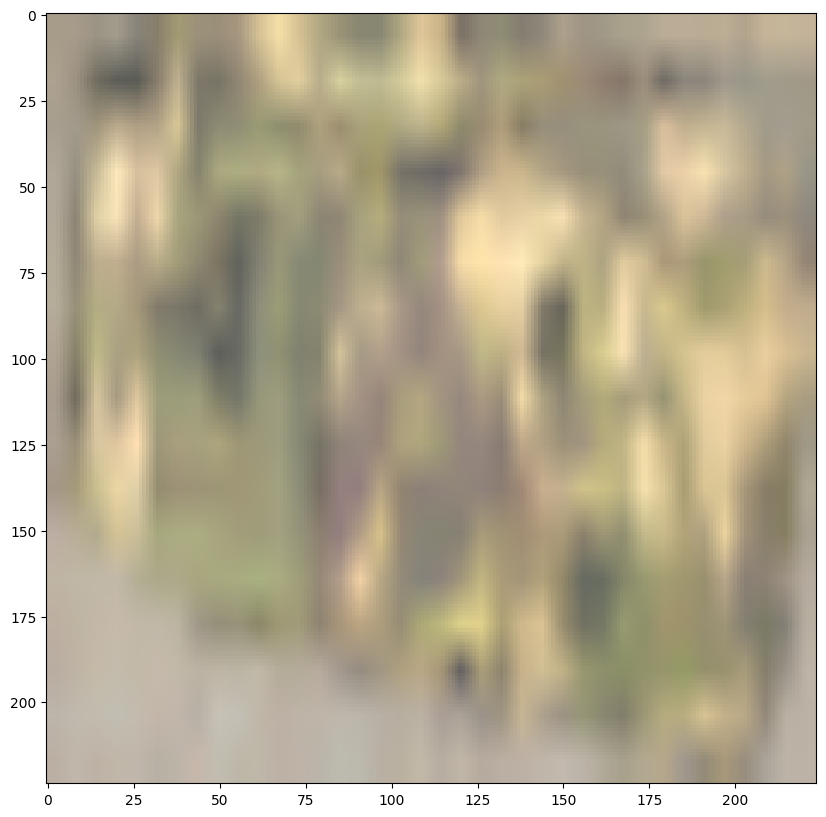

In [218]:
from utils import rs_utils
rs_utils.torch_display(img1,False,False)
rs_utils.torch_display(img2,False,False)

In [182]:
label

0